In [1]:
import torch
from models.load_model import load_model
from tools.show_images import show_images, show_pixel_distribution
from tools.get_classes import get_classes_with_index
from algorithms.single_step_attack import run_grad_cam
from visualization.reshape_tranform import ReshapeTransform
from torch.utils.data import DataLoader
from data_preprocessor.load_images import CustomDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 载入数据和模型并画图

In [10]:
dataset_file = './data_stage2/images_1000_0914.pth'
dataset = CustomDataset(dataset_file)
dataset = torch.utils.data.Subset(dataset, range(1000))
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# id_list = [3, 7, 8, 9, 10, 13]
# # id_list = [10] #[8, 9, 11] # 59 # 0
# dataset = torch.utils.data.Subset(dataset, id_list)
# dataloader = DataLoader(dataset, batch_size=len(id_list), shuffle=False)

for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)
classes = get_classes_with_index(labels)

model_str = 'vgg16'
model = load_model(model_str)

In [3]:
data_root = './data_stage3/paper_images/IoU/'

In [4]:
import torch.nn.functional as F
# 计算每张图像的预测类别和概率
def predict(model, images):
    pred_labels = []
    probabilities = []

    with torch.no_grad():  # 禁用梯度计算
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        probabilities.extend(probs.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        
    classes = get_classes_with_index(pred_labels)
    prob_list = []
    for i, pred in enumerate(pred_labels):
        percentage = f'{probabilities[i][pred]:.2%}'  # 将小数转换为百分数，保留两位小数
        prob_list.append(f'{classes[i]}:{percentage}')

    return prob_list

# 画出原始图片

In [13]:
prob_list = predict(model, images)
prob_list

['komondor:100.00%',
 'mountain_bike:68.40%',
 'jacamar:99.88%',
 'Brittany_spaniel:80.69%',
 'bolo_tie:94.24%',
 'sulphur_butterfly:100.00%',
 'sea_cucumber:99.78%',
 'running_shoe:99.64%',
 'dogsled:99.11%',
 'Norwich_terrier:99.71%',
 'Great_Pyrenees:89.99%',
 'lionfish:100.00%',
 'velvet:16.21%',
 'skunk:91.10%',
 'fly:99.96%',
 'ashcan:90.24%',
 'stone_wall:91.88%',
 'sandal:97.03%',
 'four-poster:33.87%',
 'indri:100.00%',
 'Petri_dish:50.10%',
 'robin:99.99%',
 'Shetland_sheepdog:96.52%',
 'cup:88.78%',
 'howler_monkey:98.08%',
 'Great_Pyrenees:75.40%',
 'stage:96.20%',
 'terrapin:82.63%',
 'Scotch_terrier:96.93%',
 'European_fire_salamander:97.68%',
 'American_alligator:51.26%',
 'African_chameleon:99.86%',
 'dalmatian:99.98%',
 'Ibizan_hound:99.99%',
 'marmoset:84.27%',
 'tiger_beetle:99.76%',
 'minibus:52.56%',
 'mosque:27.41%',
 'llama:100.00%',
 'strainer:34.00%',
 'ski_mask:99.68%',
 'bookshop:85.05%',
 'Dandie_Dinmont:99.87%',
 'coral_reef:56.03%',
 'obelisk:99.50%',
 'da

In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_images1(imgs, **kwargs):
    '''显示图片

    Args:
        imgs: (batch,224,224,3) numpy array, or [batch,3,224,224] tensor
        kwargs: 包含以下可选参数的字典
            titles: 标题， 长度与batch相等的list
            output_path: 输出路径，如果不为None，则保存图片到指定路径
            save_name: 保存的图片名
            scale: 图片缩放比例，默认为1.5
            main_title: 图片的大标题
            title_position: 大标题的位置，'top'表示上面，'left'表示左边，默认为'top'
    '''
    titles = kwargs.get('titles', None)
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', None)
    scale = kwargs.get('scale', 1.5)
    main_title = kwargs.get('main_title', None)
    title_position = kwargs.get('title_position', 'top')

    batch_size = imgs.shape[0]
    num_rows = kwargs.get('nrows', int(np.ceil(np.sqrt(batch_size))))
    num_cols = kwargs.get('ncols', int(np.ceil(batch_size / num_rows)))
    
    figsize = (num_cols * scale, num_rows * scale * 1.3)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    if title_position == 'top':
        fig.suptitle(main_title, fontsize=12)
        plt.subplots_adjust(top=0.90)
    elif title_position == 'left':
        fig.suptitle(main_title, fontsize=12, x=0.05, y=0.5, ha='left', rotation='vertical')
        plt.subplots_adjust(left=0.1)

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, (ax, image) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(image): # tensor
            image = image.detach().cpu().numpy().transpose(1, 2, 0)
        image_min = image.min()
        image_max = image.max()
        image = (image - image_min) / (image_max - image_min) # 归一化到0-1，否则imshow会报错
        if image.dtype != np.float32 and image.dtype != np.float64:
            image = image * 255
        ax.imshow(image)
        ax.axis("off")  
        if titles is not None:
            if '/' in titles[i]:
                ax.set_title(titles[i], fontsize=8, color='red')
            else:
                ax.set_title(titles[i], fontsize=8)
    if output_path:
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, save_name))
        plt.close()
    else:
        plt.show()

In [6]:
# 画出原始图片
# value = 0.9152
show_images(images, output_path = data_root, save_name = 'original_images', nrows = 1, ncols=len(images), main_title = 'Original Image',scale = 2)

In [ ]:
# 画出图片的像素分布
title = [f'{classes[i]}' for i in range(len(classes))]
show_pixel_distribution(images, titles = title, main_title = 'Pixel Distribution', output_path = data_root, save_name = 'pixel_distribution_20.png', ncols = 5, nrows = 4)

In [ ]:
# 画出grad-cam
import torch.nn as nn
if isinstance(model, nn.DataParallel):
    model = model.module
layers = [model.blocks[-1].norm1]
reshape_transform = ReshapeTransform(model)
use_cuda = True
grayscale_cam, vis = run_grad_cam(model, images, labels, layers, reshape_transform, use_cuda)

In [ ]:
show_images(vis, titles = title, main_title = 'Grad-CAM', output_path = data_root, save_name = 'ori_grad_cam')

# 计算LRP可视化图

In [7]:
from algorithms.LRP.lrp import LRPModel
import torch.nn as nn

x = images
model = load_model('vgg16')
# model = load_model('vit_b_16')
if isinstance(model, nn.DataParallel):
    model = model.module
    
lrp_model = LRPModel(model)
relevance_scores = lrp_model.forward(x)

In [4]:
# r = r.cpu().detach().numpy()
relevance_scores.shape

torch.Size([3, 224, 224])

In [5]:
relevance_scores.max(), relevance_scores.min()

(tensor(0.0006), tensor(3.7948e-07))

In [4]:
from algorithms.single_step_wrapper import lrp_mask_topr
mask_mode = 'lrp_topr'

mask, pixel_attacked = lrp_mask_topr(relevance_scores, lrp_topr=0.2)

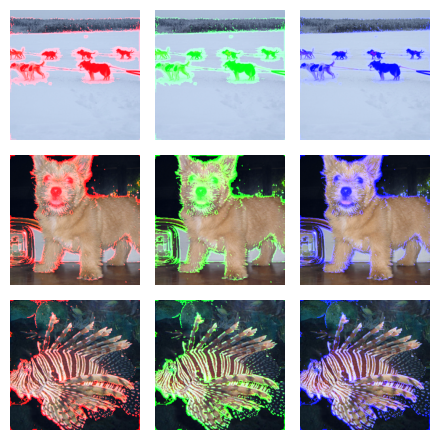

In [5]:
from tools.show_images import visualize_channel_masks_overlay
visualize_channel_masks_overlay(images, mask)

In [ ]:
from tools.show_images import plot_relevance_scores

In [ ]:
plot_relevance_scores(relevance_scores, output_path = data_root, save_name = 'vgg16_lrp.png', main_title = 'LRP', nrows = 3, ncols = 1)

# 计算梯度并画出梯度图

In [3]:
from tools.show_images import visualize_gradients

import torch
import torch.nn as nn

# 假设 images 和 labels 已经定义
images.requires_grad_(True)
outputs = model(images)

# 计算损失对输入的梯度
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, labels)
loss.backward(retain_graph=True)  # 保留计算图
# 损失函数对输入图像的梯度
loss_gradients = images.grad.clone()

# 计算输出对输入的梯度（只考虑 label 对应的类别）
images.grad.zero_()  # 清除之前的梯度
outputs[range(outputs.shape[0]), labels].sum().backward()
# 输出对输入图像的梯度
output_gradients = images.grad.clone()

# 每张图计算 Gradient × Input
grad_times_input_loss = loss_gradients * images
grad_times_input_output = output_gradients * images


In [8]:
grad_times_input_loss.shape

torch.Size([3, 3, 224, 224])

In [ ]:
# 梯度分布
# show_gradient_distribution(
#     gradients,
#     main_title='Gradient Distributions',
#     output_path=data_root,
#     save_name='ori_gradient_distributions.png',
# )
# 梯度可视化
visualize_gradients(loss_gradients, output_path=data_root, save_name='vgg16_ori_loss_gradients.png',nrows=3, ncols=1, main_title='Loss Gradients')
visualize_gradients(output_gradients, output_path=data_root, save_name='vgg16_ori_output_gradients.png',nrows=3, ncols=1, main_title='Output Gradients')

In [4]:
from tools.show_images import visualize_gradients

visualize_gradients(grad_times_input_loss, output_path=data_root, save_name='vgg16_ori_grad_times_input_loss.png',nrows=3, ncols=1, main_title='Loss Gradient \n × Input')
visualize_gradients(grad_times_input_output, output_path=data_root, save_name='vgg16_ori_grad_times_input_output.png',nrows=3, ncols=1, main_title='Output Gradient \n × Input')

In [19]:
# 生成一张纯白色的图片
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 生成一张纯白色的图片
white_image = torch.ones_like(images)
show_images(white_image, output_path = data_root, save_name = 'white_images')

In [11]:
import torch.nn.functional as F

loss_gradients = loss_gradients.view(loss_gradients.size(0), -1)  # 展平
output_gradients = output_gradients.view(output_gradients.size(0), -1)  # 展平

# 计算余弦相似度
cosine_similarity = F.cosine_similarity(loss_gradients, output_gradients, dim=1).mean().item()

# 计算皮尔逊相关系数
pearson_correlation = torch.corrcoef(torch.stack([loss_gradients.flatten(), output_gradients.flatten()]))[0, 1].item()

# 计算均方误差
mse = F.mse_loss(loss_gradients, output_gradients).item()

print(f'Cosine Similarity: {cosine_similarity:.4f}')
print(f'Pearson Correlation Coefficient: {pearson_correlation:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

Cosine Similarity: -0.1942
Pearson Correlation Coefficient: -0.1942
Mean Squared Error: 0.0000


# FGM算法和FGSM算法对比

In [6]:
import torch
import torch.nn as nn


def fgsm_test(model, X, y, eta_list):
    """ Construct FGSM adversarial examples on the examples X
    
    Args:
        model: the model
        X: the original images, [batch_size, 3, 224, 224], tensor
        y: the labels of X, [batch_size,], tensor
        eta_list: 扰动阈值 
    Returns:
        perturbation: the adversarial perturbation, [batch_size, 3, 224, 224], tensor     
    """
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    grad = delta.grad.detach().clone()
    perturbation = [eta * grad.sign() for eta in eta_list]

    return perturbation

def fgm_test(model, X, y, eta_list):
    """ Construct FGSM adversarial examples on the examples X
    
    Args:
        model: the model
        X: the original images, [batch_size, 3, 224, 224], tensor
        y: the labels of X, [batch_size,], tensor
        eta_list: 扰动阈值    
    Returns:
        perturbation: the adversarial perturbation, [batch_size, 3, 224, 224], tensor     
    """
    batch_size = X.shape[0]
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    grad = delta.grad.detach().clone()
    normed_grad =  torch.norm(grad.view(batch_size, -1), p=2, dim=1)
    perturbation = [eta * (grad / normed_grad.view(-1, 1, 1, 1)) for eta in eta_list]
    return perturbation

def predict_test(model, images):
    pred_labels = []
    probabilities = []

    with torch.no_grad():  # 禁用梯度计算
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        probabilities.extend(probs.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        
    classes = get_classes_with_index(pred_labels)
    prob_list = []
    for i, pred in enumerate(pred_labels):
        percentage = f'{probabilities[i][pred]:.2%}'  # 将小数转换为百分数，保留两位小数
        prob_list.append(f'{classes[i]}:{percentage}')

    return prob_list

In [7]:
eta_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]
delta1 = fgsm_test(model, images, labels, eta_list)
delta2 = fgm_test(model, images, labels, eta_list) 

In [8]:
attacked_images1 = torch.cat([images + delta for delta in delta1], dim=0)
attacked_images2 = torch.cat([images + delta for delta in delta2], dim=0)

prob_list1 = predict(model, attacked_images1)
prob_list2 = predict(model, attacked_images2)

In [9]:
delta1 = torch.cat([delta for delta in delta1], dim=0)
delta2 = torch.cat([delta for delta in delta2], dim=0)

In [10]:
print(prob_list)
print(prob_list1)
print(prob_list2)

['komondor:99.97%']
['komondor:99.81%', 'komondor:73.47%', 'cloak:8.16%', 'cloak:8.27%', 'cloak:7.93%', 'breastplate:6.16%', 'breastplate:14.68%', 'spider_web:32.99%', 'spider_web:94.05%']
['komondor:99.97%', 'komondor:99.96%', 'komondor:99.96%', 'komondor:99.96%', 'komondor:99.96%', 'komondor:99.96%', 'komondor:99.95%', 'komondor:99.95%', 'komondor:99.95%']


In [17]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_images1(imgs, **kwargs):
    '''显示图片

    Args:
        imgs: (batch,224,224,3) numpy array, or [batch,3,224,224] tensor
        kwargs: 包含以下可选参数的字典
            titles: 标题， 长度与batch相等的list
            output_path: 输出路径，如果不为None，则保存图片到指定路径
            save_name: 保存的图片名
            scale: 图片缩放比例，默认为1.5
            main_title: 图片的大标题
            title_position: 大标题的位置，'top'表示上面，'left'表示左边，默认为'top'
    '''
    titles = kwargs.get('titles', None)
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', None)
    scale = kwargs.get('scale', 1.5)
    main_title = kwargs.get('main_title', None)
    title_position = kwargs.get('title_position', 'top')

    batch_size = imgs.shape[0]
    num_rows = kwargs.get('nrows', int(np.ceil(np.sqrt(batch_size))))
    num_cols = kwargs.get('ncols', int(np.ceil(batch_size / num_rows)))
    
    figsize = (num_cols * scale *1.1, num_rows * scale)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    if title_position == 'top':
        fig.suptitle(main_title, fontsize=12)
        plt.subplots_adjust(top=0.90)
    elif title_position == 'left':
        fig.suptitle(main_title, fontsize=18, x=0, y=0.5, ha='left')
        plt.subplots_adjust(left=0.1)

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    all_images = np.concatenate([img.detach().cpu().numpy().transpose(1, 2, 0) if torch.is_tensor(img) else img for img in imgs], axis=0)
    global_min = all_images.min()
    global_max = all_images.max()
    
    for i, (ax, image) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(image): # tensor
            image = image.detach().cpu().numpy().transpose(1, 2, 0)
        # image_min = image.min()
        # image_max = image.max()
        image = (image - global_min) / (global_max - global_min) # 归一化到0-1，否则imshow会报错
        if image.dtype != np.float32 and image.dtype != np.float64:
            image = image * 255
        ax.imshow(image)
        ax.axis("off")  
        if titles is not None:
            if '/' in titles[i]:
                ax.set_title(titles[i], fontsize=11, color='red')
            else:
                ax.set_title(titles[i], fontsize=11)
    if output_path:
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(os.path.join(output_path, save_name))
        plt.close()
    else:
        plt.show()

In [18]:
ncols = len(eta_list)
title_delta = [f'eta={eta}' for eta in eta_list]

show_images1(delta1, nrows=1, ncols=ncols, main_title='FGSM_delta', output_path=data_root, save_name='fgsm', titles=title_delta, scale=2, title_position='left')
show_images1(delta2, nrows=1, ncols=ncols, main_title='FGM_delta', output_path=data_root, save_name='fgm', titles=title_delta, scale=2, title_position='left')

show_images1(attacked_images1, nrows=1, ncols=ncols, main_title='FGSM_Attacked', output_path=data_root, save_name='fgsm_attacked', titles=prob_list1, scale=2, title_position='left')
show_images1(attacked_images2, nrows=1, ncols=ncols, main_title='FGM_Attacked', output_path=data_root, save_name='fgm_attacked', titles=prob_list2, scale=2, title_position='left')


In [9]:
# 多步法
from algorithms.i_fgsm import i_fgsm
from algorithms.i_fgm import i_fgm

In [10]:
alpha = 1e-3
eta=0.1
num_steps = 1000
delta1 = i_fgsm(model, images, labels, alpha, eta, num_steps)
delta2 = i_fgm(model, images, labels, alpha, eta, num_steps)

In [13]:
title_delta = [f'eta={eta}' for _ in range(3)]
title_delta

['eta=0.1', 'eta=0.1', 'eta=0.1']

In [11]:
attacked_images1 = images + delta1
attacked_images2 = images + delta2

prob_list1 = predict(model, attacked_images1)
prob_list2 = predict(model, attacked_images2)

print(prob_list)    
print(prob_list1)
print(prob_list2)

['dogsled:97.28%', 'Norwich_terrier:97.35%', 'lionfish:99.08%']
['beagle:99.95%', 'soft-coated_wheaten_terrier:99.95%', 'snorkel:99.10%']
['Walker_hound:43.44%', 'Norwich_terrier:75.79%', 'lionfish:87.09%']


In [18]:
show_images1(delta1, nrows=3, ncols=1, main_title='I-FGSM_delta', output_path=data_root, save_name='i_fgsm', titles=title_delta, scale=2)
show_images1(delta2, nrows=3, ncols=1, main_title='I-FGM_delta', output_path=data_root, save_name='i_fgm', titles=title_delta, scale=2)

show_images1(attacked_images1, nrows=3, ncols=1, main_title='I-FGSM_Attacked', output_path=data_root, save_name='i_fgsm_attacked', titles=prob_list1, scale=2)
show_images1(attacked_images2, nrows=3, ncols=1, main_title='I-FGM_Attacked', output_path=data_root, save_name='i_fgm_attacked', titles=prob_list2, scale=2)

# 可视化被攻击的pixel和扰动

# IOU

In [5]:
from algorithms.single_step_attack import OneStepAttack
from algorithms.multi_step_attack import MultiStepAttack
from tools.show_images import visualize_channel_masks_overlay
import os

root = data_root

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_channel_masks_overlay1(images, masks, **kwargs):
    '''
    Overlay masks on the original images.

    Args:
        images: Tensor of images, shape (batch_size, channels, height, width)
        masks: Tensor of masks, same shape as images
        kwargs: Optional parameters
    '''
    titles = kwargs.get('titles', None)
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', 'mask_overlay_visualization.png')
    scale = kwargs.get('scale', 3)
    main_title = kwargs.get('main_title', None)

    batch_size = images.shape[0]
    channels = images.shape[1]

    num_rows = batch_size
    num_cols = channels

    figsize = (num_cols * scale, num_rows * scale)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    if main_title:
        fig.suptitle(main_title, fontsize=30)

    for i in range(batch_size):
        for j in range(channels):
            ax = axs[i, j] if batch_size > 1 else axs[j]
            image_i = images[i].cpu().detach().numpy().transpose(1, 2, 0)
            mask_i = masks[i, j].cpu().detach().numpy()
            # Normalize image to [0, 1] for visualization
            image_i = (image_i - image_i.min()) / (image_i.max() - image_i.min())
            # Create an overlay by adding the mask to the image
            overlay = image_i.copy()
            overlay[:, :, j] = np.clip(overlay[:, :, j] + mask_i, 0, 1)  # Highlight mask regions in the corresponding channel
            ax.imshow(overlay)
            ax.axis('off')
            if titles is not None:
                if '/' in titles[i]:
                    ax.set_title(titles[i], fontsize=8, color='red')
                else:
                    ax.set_title(titles[i], fontsize=8)

    plt.tight_layout()
    if output_path:
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        output_file = os.path.join(output_path, save_name)
        plt.savefig(output_file)
        plt.close()
    else:
        plt.show()

In [7]:
def jaccard_similarity(mask_a, mask_b):
    mask_a = mask_a.bool()
    mask_b = mask_b.bool()
    intersection = (mask_a & mask_b).float().sum().item()  # 同时为1的元素个数
    union = (mask_a | mask_b).float().sum().item()  # 两个mask中为1的元素个数
    return intersection / union

In [11]:
import pandas as pd
from tqdm import tqdm

# 单步法攻击
algo = 'fgsm'
eta_list = [0.01]
show = False
mask_mode_para_dict = {
    'topr': [0.5],
    'lowr': [0.5],
    'channel_topr': [0.5],
    'channel_lowr': [0.5],
    'seed_randomr': [0.5],
    'seed_randomr_lowr': [0.5],
    'cam_topr': [0.5],
    'cam_lowr': [0.5],
    'lrp_topr': [0.5],
    'lrp_lowr': [0.5],
}

results = []

for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Batches", leave=False), 1):  # 1表示从1开始计数
    for mask_mode, parameter_list in mask_mode_para_dict.items():
        for parameter in parameter_list:
            attacker = OneStepAttack(model_str, images, labels, root)
            if parameter is None:
                pixel_attacked, success_rate_dict, attack_ratio_per_channel, l1_norm, l2_norm_squre, original_loss, loss_dict_attacked, pred_loss_dict, mask = attacker.attack(algo=algo, eta_list=eta_list, show=show, mask_mode=mask_mode)
            else:
                pixel_attacked, success_rate_dict, attack_ratio_per_channel, l1_norm, l2_norm_squre, original_loss, loss_dict_attacked, pred_loss_dict, mask = attacker.attack(algo=algo, eta_list=eta_list, show=show, mask_mode=mask_mode, **{mask_mode: parameter})
                if mask_mode == 'topr':
                    mask_topr = mask
                iou = jaccard_similarity(mask, mask_topr)
                eta = eta_list[0]
                success_rate = success_rate_dict[eta]
                results.append({
                    'eta': eta,
                    'mask_mode': mask_mode,
                    'parameter': parameter,
                    'iou': iou,
                    'success_rate': success_rate,
                    'batch_idx': batch_idx
                })
                # print(f'{mask_mode} mask_iou: {iou:.4f}')

# 将结果保存为DataFrame
df_results = pd.DataFrame(results)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6567
channel_lowr mask_iou: 0.1156
seed_randomr mask_iou: 0.3333
seed_randomr_lowr mask_iou: 0.3334
cam_topr mask_iou: 0.3907
cam_lowr mask_iou: 0.2805
lrp_topr mask_iou: 0.3816


Batches:  10%|█         | 1/10 [00:19<02:52, 19.15s/it]

lrp_lowr mask_iou: 0.2883
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6626
channel_lowr mask_iou: 0.1129
seed_randomr mask_iou: 0.3335
seed_randomr_lowr mask_iou: 0.3332
cam_topr mask_iou: 0.4031
cam_lowr mask_iou: 0.2701
lrp_topr mask_iou: 0.3948


Batches:  20%|██        | 2/10 [00:37<02:30, 18.86s/it]

lrp_lowr mask_iou: 0.2770
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6623
channel_lowr mask_iou: 0.1131
seed_randomr mask_iou: 0.3335
seed_randomr_lowr mask_iou: 0.3332
cam_topr mask_iou: 0.4068
cam_lowr mask_iou: 0.2672
lrp_topr mask_iou: 0.3928


Batches:  30%|███       | 3/10 [00:56<02:11, 18.85s/it]

lrp_lowr mask_iou: 0.2787
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6591
channel_lowr mask_iou: 0.1145
seed_randomr mask_iou: 0.3332
seed_randomr_lowr mask_iou: 0.3334
cam_topr mask_iou: 0.3938
cam_lowr mask_iou: 0.2779
lrp_topr mask_iou: 0.3856


Batches:  40%|████      | 4/10 [01:15<01:53, 18.92s/it]

lrp_lowr mask_iou: 0.2848
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6558
channel_lowr mask_iou: 0.1160
seed_randomr mask_iou: 0.3332
seed_randomr_lowr mask_iou: 0.3335
cam_topr mask_iou: 0.3967
cam_lowr mask_iou: 0.2754
lrp_topr mask_iou: 0.3885


Batches:  50%|█████     | 5/10 [01:34<01:34, 18.95s/it]

lrp_lowr mask_iou: 0.2824
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6653
channel_lowr mask_iou: 0.1117
seed_randomr mask_iou: 0.3333
seed_randomr_lowr mask_iou: 0.3333
cam_topr mask_iou: 0.4067
cam_lowr mask_iou: 0.2672
lrp_topr mask_iou: 0.4005


Batches:  60%|██████    | 6/10 [01:54<01:17, 19.37s/it]

lrp_lowr mask_iou: 0.2723
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6557
channel_lowr mask_iou: 0.1160
seed_randomr mask_iou: 0.3335
seed_randomr_lowr mask_iou: 0.3332
cam_topr mask_iou: 0.3970
cam_lowr mask_iou: 0.2752
lrp_topr mask_iou: 0.3899


Batches:  70%|███████   | 7/10 [02:13<00:57, 19.27s/it]

lrp_lowr mask_iou: 0.2812
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6564
channel_lowr mask_iou: 0.1157
seed_randomr mask_iou: 0.3332
seed_randomr_lowr mask_iou: 0.3334
cam_topr mask_iou: 0.3900
cam_lowr mask_iou: 0.2811
lrp_topr mask_iou: 0.3838


Batches:  80%|████████  | 8/10 [02:32<00:38, 19.16s/it]

lrp_lowr mask_iou: 0.2864
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6566
channel_lowr mask_iou: 0.1156
seed_randomr mask_iou: 0.3333
seed_randomr_lowr mask_iou: 0.3333
cam_topr mask_iou: 0.3981
cam_lowr mask_iou: 0.2743
lrp_topr mask_iou: 0.3872


Batches:  90%|█████████ | 9/10 [02:52<00:19, 19.29s/it]

lrp_lowr mask_iou: 0.2835
topr mask_iou: 1.0000
lowr mask_iou: 0.0000
channel_topr mask_iou: 0.6584
channel_lowr mask_iou: 0.1148
seed_randomr mask_iou: 0.3334
seed_randomr_lowr mask_iou: 0.3332
cam_topr mask_iou: 0.4011
cam_lowr mask_iou: 0.2718
lrp_topr mask_iou: 0.3890


lrp_lowr mask_iou: 0.2820


In [12]:
df_results.head()

,eta,mask_mode,parameter,iou,success_rate,batch_idx
0,0.01,topr,0.5,1.000000,0.74,1
1,0.01,lowr,0.5,0.000000,0.17,1
2,0.01,channel_topr,0.5,0.656733,0.73,1
3,0.01,channel_lowr,0.5,0.115570,0.22,1
4,0.01,seed_randomr,0.5,0.333309,0.60,1


In [18]:
def merge_batch(data): 
    '''将多个batch的数据合并'''
    li = ['eta', 'mask_mode', 'parameter']
    data_grouped = data.groupby(li).agg({
        'success_rate': lambda x: round(x.mean(), 4),
        'iou': lambda x: round(x.mean(), 4),
    }).reset_index()
    return data_grouped

In [19]:
data = merge_batch(df_results)
print(data.shape)
data.head()

(10, 5)


,eta,mask_mode,parameter,success_rate,iou
0,0.01,cam_lowr,0.5,0.354,0.2741
1,0.01,cam_topr,0.5,0.569,0.3984
2,0.01,channel_lowr,0.5,0.155,0.1146
3,0.01,channel_topr,0.5,0.728,0.6589
4,0.01,lowr,0.5,0.114,0.0000


In [20]:
mask_mode_list = ['topr', 'channel_topr', 'lrp_topr', 'cam_topr', 'seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'lrp_lowr', 'channel_lowr', 'lowr']

# 将 mask_mode 列转换为分类类型，并指定类别顺序
data['mask_mode'] = pd.Categorical(data['mask_mode'], categories=mask_mode_list, ordered=True)

# 按照 mask_mode 列排序
data = data.sort_values('mask_mode')

data

,eta,mask_mode,parameter,success_rate,iou
9,0.01,topr,0.5,0.753,1.0000
3,0.01,channel_topr,0.5,0.728,0.6589
6,0.01,lrp_topr,0.5,0.627,0.3894
1,0.01,cam_topr,0.5,0.569,0.3984
7,0.01,seed_randomr,0.5,0.544,0.3334
8,0.01,seed_randomr_lowr,0.5,0.543,0.3333
0,0.01,cam_lowr,0.5,0.354,0.2741
5,0.01,lrp_lowr,0.5,0.328,0.2817
2,0.01,channel_lowr,0.5,0.155,0.1146
4,0.01,lowr,0.5,0.114,0.0000


In [21]:
data.to_excel(os.path.join(root, 'fgsm_results.xlsx'), index=False)

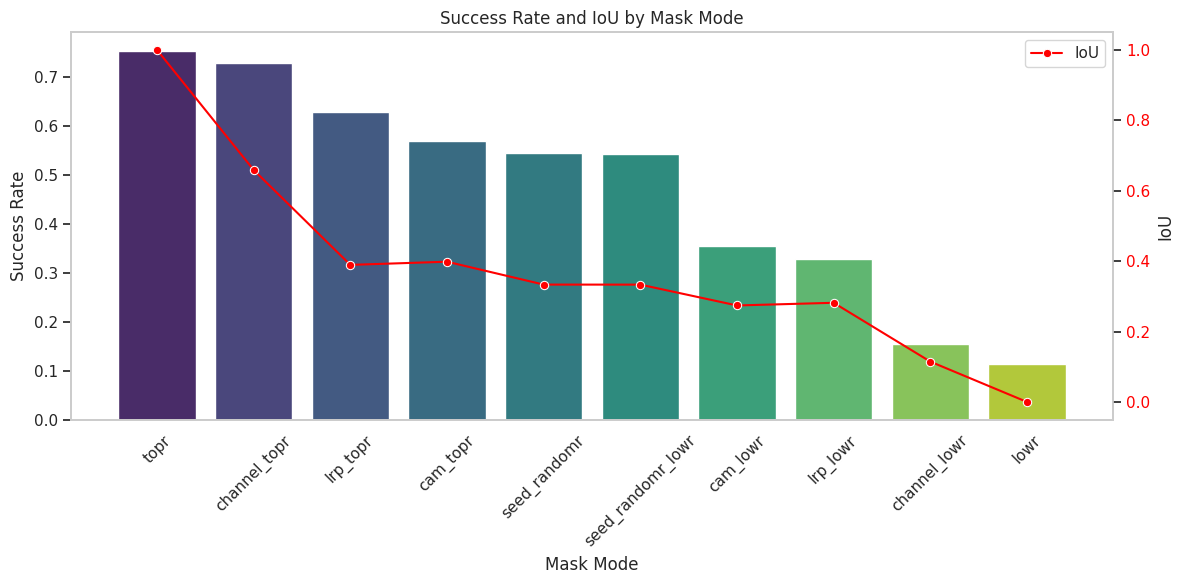

In [26]:
# 设置绘图风格
import seaborn as sns
import matplotlib.pyplot as plt

# 设置绘图风格
sns.set(style="whitegrid")

# 创建一个图形
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制 success_rate 的条形图
sns.barplot(x='mask_mode', y='success_rate', data=data, ax=ax1, palette='viridis')
ax1.set_title('Success Rate and IoU by Mask Mode')
ax1.set_xlabel('Mask Mode')
ax1.set_ylabel('Success Rate')
ax1.tick_params(axis='x', rotation=45)

# 添加柱形图图例
# handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles, ['Success Rate'], loc='upper left')

# 创建第二个纵坐标轴
ax2 = ax1.twinx()
sns.lineplot(x='mask_mode', y='iou', data=data, ax=ax2, color='red', marker='o', label='IoU')
ax2.set_ylabel('IoU')
ax2.tick_params(axis='y', labelcolor='red')

# 移除网格线
ax1.grid(False)
ax2.grid(False)

# 显示图例
ax2.legend(loc='upper right')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [ ]:
mask1 = mask[0, 0].int()
mask2 = mask[0, 1].int()
mask3 = mask[0, 2].int()

def dice_coefficient(mask_a, mask_b):
    intersection = (mask_a & mask_b).float().sum().item()
    return 2 * intersection / (mask_a.float().sum().item() + mask_b.float().sum().item())

def overlap_ratio(mask_a, mask_b):
    intersection = (mask_a & mask_b).float().sum().item()
    return intersection / mask_a.float().sum().item()

# 计算相似度
jaccard_12 = jaccard_similarity(mask1, mask2)
jaccard_13 = jaccard_similarity(mask1, mask3)
jaccard_23 = jaccard_similarity(mask2, mask3)

dice_12 = dice_coefficient(mask1, mask2)
dice_13 = dice_coefficient(mask1, mask3)
dice_23 = dice_coefficient(mask2, mask3)

overlap_12 = overlap_ratio(mask1, mask2)
overlap_13 = overlap_ratio(mask1, mask3)
overlap_23 = overlap_ratio(mask2, mask3)

print(f'Jaccard Similarity between Channel 1 and 2: {jaccard_12:.4f}')
print(f'Jaccard Similarity between Channel 1 and 3: {jaccard_13:.4f}')
print(f'Jaccard Similarity between Channel 2 and 3: {jaccard_23:.4f}')

print(f'Dice Coefficient between Channel 1 and 2: {dice_12:.4f}')
print(f'Dice Coefficient between Channel 1 and 3: {dice_13:.4f}')
print(f'Dice Coefficient between Channel 2 and 3: {dice_23:.4f}')

print(f'Overlap Ratio between Channel 1 and 2: {overlap_12:.4f}')
print(f'Overlap Ratio between Channel 1 and 3: {overlap_13:.4f}')
print(f'Overlap Ratio between Channel 2 and 3: {overlap_23:.4f}')

Jaccard Similarity between Channel 1 and 2: 0.0544
Jaccard Similarity between Channel 1 and 3: 0.0551
Jaccard Similarity between Channel 2 and 3: 0.0574
Dice Coefficient between Channel 1 and 2: 0.1032
Dice Coefficient between Channel 1 and 3: 0.1044
Dice Coefficient between Channel 2 and 3: 0.1085
Overlap Ratio between Channel 1 and 2: 0.1021
Overlap Ratio between Channel 1 and 3: 0.1047
Overlap Ratio between Channel 2 and 3: 0.1100


In [ ]:
# 多步法攻击
attacker = MultiStepAttack(model_str, images, labels, root, steps=300, nrows=1, ncols=1)
success_rate_dict, loss_dict, l1_norm_dict, l2_norm_squre_dict, pred_loss_dict, attacked_images = attacker.attack(algo='i_fgsm', alpha=1e-4, eta=0.01, mask_mode=mask_mode, early_stopping=False,show=True)

# 画出不同层的Grad-CAM可视化图

In [ ]:
import torch
from models.load_model import load_model
from tools.show_images import show_images
from tools.get_classes import get_classes_with_index, get_chinese_classes_with_index
from main.single_step_attack import run_grad_cam
from visualization.reshape_tranform import ReshapeTransform
from torch.utils.data import DataLoader, Subset
from data_preprocessor.load_images import CustomDataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dataset_file = './data_stage2/images_100_0911.pth'
dataset = CustomDataset(dataset_file)
# dataset = torch.utils.data.Subset(dataset, range(100)) 
# idx_list = [8, 9, 11]
# dataset = Subset(dataset, idx_list)
# dataloader = DataLoader(dataset, batch_size=3, shuffle=False)
# for images, labels in dataloader:
#     images = images.to(device)
#     labels = labels.to(device)
#     english_classes = get_classes_with_index(labels)
#     print(english_classes)
#     chinese_classes = get_chinese_classes_with_index(labels)
#     print(chinese_classes)

In [ ]:
model_str = 'vit_b_16'
model = load_model(model_str)

In [ ]:
import torch.nn as nn
if isinstance(model, nn.DataParallel):
    model = model.module
layers = [[model.pos_drop], [model.blocks[0].mlp], [model.blocks[1].mlp],[model.blocks[2].mlp],
    [model.blocks[3].mlp],[model.blocks[4].mlp],[model.blocks[5].mlp],[model.blocks[6].mlp],
    [model.blocks[7].mlp],[model.blocks[8].mlp] ,[model.blocks[9].mlp],[model.blocks[10].mlp],
    [model.blocks[-1].norm1]]
reshape_transform = ReshapeTransform(model)
use_cuda = True
idx_list = [8, 9, 11]

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

def save_single_image_layers_cam(model, dataset, idx_list, layers, reshape_transform, use_cuda):
    
    dataset = Subset(dataset, idx_list)
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    layernames = []
    for i, layer in enumerate(layers):
        for sublayer in layer:
            layernames.append(f'Layer_{i}_{sublayer.__class__.__name__}')
            
    all_images_paths = []
    all_data_root = []
    root = './data_stage2/Grad_CAM'
    for j, (images, labels) in enumerate(dataloader):
        if j == 0:
            show = True
        else:
            show = False
        images = images.to(device)
        labels = labels.to(device)
    
        classes = get_classes_with_index(labels)
        title = [f'{classes[i]}' for i in range(len(classes))]
        
        data_root = root + f'/{classes[0]}'
        all_data_root.append(data_root)
        
        show_images(images, output_path=data_root, titles=title, save_name='original_images.png')
        for i, layer in enumerate(layers):
            grayscale_cam, vis = run_grad_cam(model, images, labels, layer, reshape_transform, use_cuda)
            show_images(vis, output_path=data_root, save_name=f'{layernames[i]}.png')
            print(f'{classes}, {layernames[i]} done')
        
        fig, axs = plt.subplots(1, len(layers) + 1, figsize=(60, 5))

        for i in range(len(layernames) + 1):
            if i == 0:
                img_path = os.path.join(data_root, 'original_images.png')
                img = mpimg.imread(img_path)
                axs[i].imshow(img)
                if show:
                    axs[i].set_title('original_images', fontsize=28)
                axs[i].axis('off')
            else:
                img_path = os.path.join(data_root, f'{layernames[i-1]}.png')
                img = mpimg.imread(img_path)
                axs[i].imshow(img)
                if show:
                    axs[i].set_title(layernames[i-1], fontsize=28)
                axs[i].axis('off')

        plt.tight_layout()
        all_layers_path = os.path.join(data_root, 'all_layers.png')
        plt.savefig(all_layers_path)
        all_images_paths.append(all_layers_path)
        plt.close(fig)
    
    # 合并所有 all_layers.png 图片为一张大图
    images = [Image.open(x) for x in all_images_paths]
    widths, heights = zip(*(img.size for img in images))

    total_height = int(sum(heights))
    max_width = max(widths)

    combined_image = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for img in images:
        combined_image.paste(img, (0, y_offset))
        y_offset += img.height

    combined_image.save(os.path.join(root, 'combined_all_layers.png'))
    
    # 删除所有data_root文件夹
    for path in all_data_root:
        os.system(f'rm -r {path}')

In [ ]:
save_single_image_layers_cam(model, dataset, idx_list, layers, reshape_transform, use_cuda)

['dogsled'], Layer_0_Dropout done
['dogsled'], Layer_1_Mlp done
['dogsled'], Layer_2_Mlp done
['dogsled'], Layer_3_Mlp done
['dogsled'], Layer_4_Mlp done
['dogsled'], Layer_5_Mlp done
['dogsled'], Layer_6_Mlp done
['dogsled'], Layer_7_Mlp done
['dogsled'], Layer_8_Mlp done
['dogsled'], Layer_9_Mlp done
['dogsled'], Layer_10_Mlp done
['dogsled'], Layer_11_Mlp done
['dogsled'], Layer_12_LayerNorm done
['Norwich_terrier'], Layer_0_Dropout done
['Norwich_terrier'], Layer_1_Mlp done
['Norwich_terrier'], Layer_2_Mlp done
['Norwich_terrier'], Layer_3_Mlp done
['Norwich_terrier'], Layer_4_Mlp done
['Norwich_terrier'], Layer_5_Mlp done
['Norwich_terrier'], Layer_6_Mlp done
['Norwich_terrier'], Layer_7_Mlp done
['Norwich_terrier'], Layer_8_Mlp done
['Norwich_terrier'], Layer_9_Mlp done
['Norwich_terrier'], Layer_10_Mlp done
['Norwich_terrier'], Layer_11_Mlp done
['Norwich_terrier'], Layer_12_LayerNorm done
['lionfish'], Layer_0_Dropout done
['lionfish'], Layer_1_Mlp done
['lionfish'], Layer_2_Ml

rm: cannot remove './data_stage2/Grad_CAM/dogsled/.nfs0000000028b1946a00000bac': Device or resource busy
rm: cannot remove './data_stage2/Grad_CAM/Norwich_terrier/.nfs0000000028b194bf00000bad': Device or resource busy
rm: cannot remove './data_stage2/Grad_CAM/lionfish/.nfs0000000028b194d200000bae': Device or resource busy


# ppt插图绘制

In [ ]:
import os
from collections import defaultdict

def list_all_files(directory):
    file_paths = defaultdict(list)
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths[root].append(file)
    return file_paths

# 使用示例
directory = 'data_stage3/vis_multi_step_1030/vit_b_16'
all_files = list_all_files(directory)
print(all_files)

defaultdict(<class 'list'>, {'data_stage3/vis_multi_step_1030/vit_b_16': ['vit_b_16_vis_result_multi_step_1030.xlsx', 'ori_images.png', 'ori_grad_cam.png'], 'data_stage3/vis_multi_step_1030/vit_b_16/channel_lowr/0.8': ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 'data_stage3/vis_multi_step_1030/vit_b_16/positive': ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 'data_stage3/vis_multi_step_1030/vit_b_16/randomr/0.2': ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 'data_stage3/vis_multi_step_1030/vit_b_16/all': ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_ima

{'data_stage3/vis_multi_step_1030/vit_b_16': 
['vit_b_16_vis_result_multi_step_1030.xlsx', 'ori_images.png', 'ori_grad_cam.png'], 

'data_stage3/vis_multi_step_1030/vit_b_16/channel_lowr/0.8': 
['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 

'data_stage3/vis_multi_step_1030/vit_b_16/positive':
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/randomr/0.2': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/all': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], '
 
 data_stage3/vis_multi_step_1030/vit_b_16/channel_topr/0.2': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/negative': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/seed_randomr_lowr/0.8': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/topr/0.2': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/cam_lowr/0.8': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/seed_randomr/0.2': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/cam_topr/0.2': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png'], 
 
 'data_stage3/vis_multi_step_1030/vit_b_16/lowr/0.8': 
 ['ori_gradient.png', 'mask_overlay_visualization_step299.png', 'delta_step299.png', 'gradient_step299.png', 'adversarial_images_step299.png', 'grad_cam_step299.png']}

# 计算梯度大于0和小于0的比例

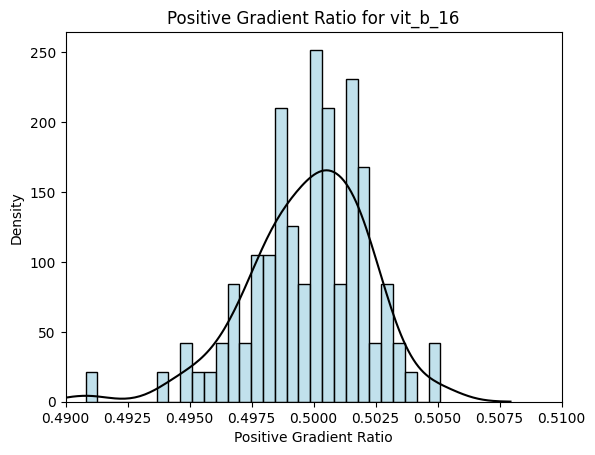

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from models.load_model import load_model
from tools.get_classes import get_classes_with_index
from data_preprocessor.load_images import CustomDataset

# 加载数据集
dataset_file = './data_stage2/images_100_0911.pth'
dataset = CustomDataset(dataset_file)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# 定义模型列表
model_list = ['vit_b_16', 'resnet50', 'vgg16']
data_root = './data_stage3/paper_images'

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 计算梯度并画图
for model_str in model_list:
    model = load_model(model_str)
    model.eval()
    
    positive_grad_ratios = []
    
    for images, labels in dataloader:
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        model.zero_grad()
        loss.backward()
        
        gradients = images.grad
        
        # 对每张图像分别统计梯度为正的比例
        for i in range(images.size(0)):
            positive_grad_ratio = (gradients[i] > 0).float().mean().item()
            positive_grad_ratios.append(positive_grad_ratio)

    # 画直方图并叠加分布线
    plt.figure()
    sns.histplot(positive_grad_ratios, bins=30, edgecolor='black', color='lightblue', stat='density')
    sns.kdeplot(positive_grad_ratios, color='black')
    plt.title(f'Positive Gradient Ratio for {model_str}')
    plt.xlabel('Positive Gradient Ratio')
    plt.ylabel('Density')
    plt.xlim(0.49, 0.51)
    plt.savefig(f'{data_root}/{model_str}_positive_grad_ratio_hist.png')
    plt.show()

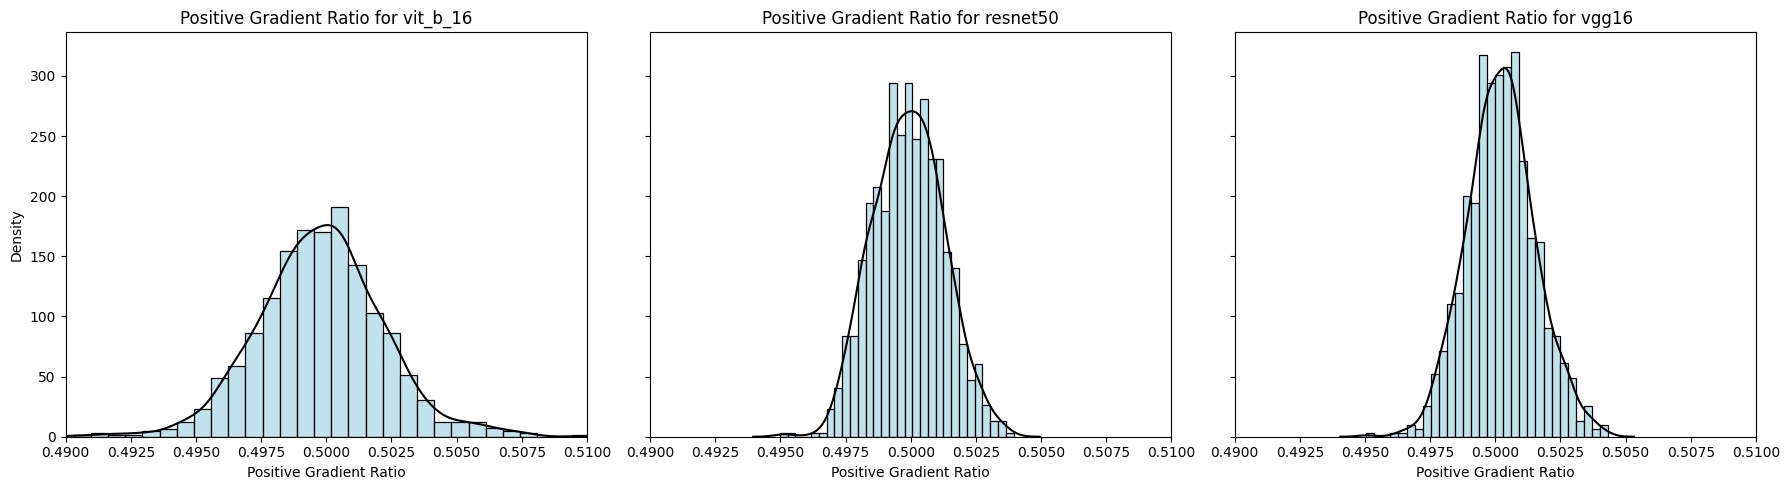

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from models.load_model import load_model
from tools.get_classes import get_classes_with_index
from data_preprocessor.load_images import CustomDataset

# 加载数据集
# dataset_file = './data_stage2/images_100_0911.pth'
dataset_file = './data_stage2/images_1000_0914.pth'
dataset = CustomDataset(dataset_file)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# 定义模型列表
model_list = ['vit_b_16', 'resnet50', 'vgg16']
data_root = './data_stage3/paper_images'

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 创建子图
fig, axes = plt.subplots(1, len(model_list), figsize=(18, 5), sharey=True)

# 计算梯度并画图
for idx, model_str in enumerate(model_list):
    model = load_model(model_str)
    model.eval()
    
    positive_grad_ratios = []
    
    for images, labels in dataloader:
        images.requires_grad = True
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        model.zero_grad()
        loss.backward()
        
        gradients = images.grad
        
        # 对每张图像分别统计梯度为正的比例
        for i in range(images.size(0)):
            positive_grad_ratio = (gradients[i] > 0).float().mean().item()
            positive_grad_ratios.append(positive_grad_ratio)

    # 画直方图并叠加分布线
    sns.histplot(positive_grad_ratios, bins=30, edgecolor='black', color='lightblue', stat='density', ax=axes[idx])
    sns.kdeplot(positive_grad_ratios, color='black', ax=axes[idx])
    axes[idx].set_title(f'Positive Gradient Ratio for {model_str}')
    axes[idx].set_xlabel('Positive Gradient Ratio')
    axes[idx].set_xlim(0.49, 0.51)

axes[0].set_ylabel('Density')
plt.tight_layout()
plt.savefig(f'{data_root}/positive_grad_ratio_hist_all_models.png')
plt.show()

# 不同模型的梯度可视化

In [13]:
from tools.show_images import visualize_gradients

import torch
import torch.nn as nn

# 假设 images 和 labels 已经定义

model_list = ['vit_b_16', 'resnet50', 'vgg16']
for model_str in model_list:
    model = load_model(model_str)
    model.eval()
    images.requires_grad_(True)
    outputs = model(images)

    # 计算损失对输入的梯度
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    loss.backward(retain_graph=True)  # 保留计算图
    # 损失函数对输入图像的梯度
    loss_gradients = images.grad.clone()
    visualize_gradients(loss_gradients, output_path=data_root, save_name=f'{model_str}_loss_gradients.png',nrows=1, ncols=len(images), main_title='Loss Gradients')
    
    images.grad.zero_()
    